<a href="https://colab.research.google.com/github/madaan/reasoning-tutorial/blob/main/Part_2_Prompting_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few-shot/0-shot prompting introduction

In [ ]:
!pip install openai --quiet
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from tqdm import tqdm
import openai
from importlib import reload

reload(openai)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.3 MB/s eta 0:00:00


<module 'openai' from '/usr/local/lib/python3.10/dist-packages/openai/__init__.py'>

#### LLM tooling setup


In [ ]:
openai.api_key = "NONE"
# you will need a key for the actual openai API

openai.api_base = "http://pitt.lti.cs.cmu.edu:8002/v1"


# To use chatgpt, set engine_name to gpt-3.5-turbo and unset api_base
# You may have to reaload openai

def call_openai_chatcompletion_api(
    prompt: str,
    engine_name: str = "meta-llama/Llama-2-70b-chat-hf",
    temperature: float = 0.0,
    n: int = 1,
    stop: str = None,
    max_tokens: int = 100,
    batch_size: int = 32
):
    """
    Call the OpenAI API to create completions based on the input prompt.

    Parameters:
    - prompt (str): The prompt.
    - engine_name (str, optional): The engine to use for the completion.
    - temperature (float, optional): Sampling temperature for randomness. Defaults to 0.0.
    - n (int, optional): Number of completions to generate. Defaults to 1.
    - stop (str, optional): Token at which the API should stop generating further tokens. Defaults to '\n'.
    - max_tokens (int, optional): Maximum number of tokens in the generated output. Defaults to 100.
    - batch_size (int, optional): Maximum num_completions for each API call. Defaults to 32.

    Returns:
    - list/str: Generated text completions from the API. Returns a list of strings if n > 1, else a single string.
    """
    all_responses = []
    orig_n = n

    messages=[{
        "role": "system",
        "content": "You are a helpful assistant."
    }, {
        "role": "user",
        "content": prompt
    }]

    try:
        while n > 0:
            current_batch_size = min(n, batch_size)

            response = openai.ChatCompletion.create(
                        model=engine_name,
                        messages=messages,
                        temperature=temperature,
                        max_tokens=max_tokens,
                        n=current_batch_size,
                        stop=stop,
                    )

            all_responses.extend([choice["message"]["content"] for choice in response['choices']])

            n -= current_batch_size

        return all_responses if orig_n > 1 else all_responses[0]

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None



### Prompting basics

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define the interactive module
class FewShotPrompting:
    def __init__(self):
        self.textarea = widgets.Textarea(
            value='',
            placeholder='Type your prompt here...',
            description='',
            disabled=False,
            layout=widgets.Layout(height='200px', width='80%'),
            style={'description_width': 'initial', 'font_size': '16px'}
        )
        self.submit_button = widgets.Button(
            description="Submit",
            button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to get a response',
            icon='',
            layout=widgets.Layout(width='20%')
        )
        self.output = widgets.Output()

        self.submit_button.on_click(self.on_submit)
        display(widgets.VBox([widgets.Label(value="Prompt:"), self.textarea, self.submit_button, self.output]))

    def on_submit(self, button, engine_name = "meta-llama/Llama-2-70b-chat-hf"):
        with self.output:
            clear_output(wait=True)
            prompt = self.textarea.value
            if not prompt:
                print("Please enter a prompt.")
                return

            # Call the OpenAI API
            response = call_openai_chatcompletion_api(prompt, engine_name)
            print(f"Response:\n\n{response}")

# Create an instance to display the interactive module
FewShotPrompting()
print("")

### Interesting applications of prompting

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def get_response(prompt):
    response = call_openai_chatcompletion_api(prompt, "meta-llama/Llama-2-70b-chat-hf", max_tokens=500)
    return response

def on_button_click(button):
    prompt = text.value
    output_area.value = "Processing... Please wait..."
    response = get_response(prompt)
    output_area.value = f"Response:\n\n{response}"

tasks = {
    "Descriptive Writing": "Describe a serene and peaceful evening on a beach.",
    "Question & Answer": "Explain the concept of quantum entanglement in simple terms.",
    "Translation": "Translate the following English sentence to French: 'Hello, how are you?'",
    "Math Problem Solving": "Solve the quadratic equation x^2 - 5x + 6 = 0.",
    "Code Writing": "Write a Python function that calculates the factorial of a number.",
    "Historical Facts": "Tell me about the Renaissance period.",
}

def on_dropdown_change(change):
    text.value = change['new']

dropdown = widgets.Dropdown(
    options=tasks,
    description='Task:',
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)
dropdown.observe(on_dropdown_change, names='value')

text = widgets.Textarea(
    value=dropdown.value,
    placeholder='Type your prompt here...',
    layout=widgets.Layout(width='80%', height='100px', margin='20px 0 20px 0'),
    description='',
    disabled=False
)

output_style = {
    'description_width': 'initial',
    'font_size': '16px',
    'font_family': 'Courier New',
    'background_color': '#f7f7f7'
}

output_area = widgets.Textarea(
    value="",
    placeholder='Response will appear here...',
    layout=widgets.Layout(width='80%', height='200px', border='2px solid #0077b6', margin='20px 0 20px 0'),
    style=output_style,
    disabled=True
)

button = widgets.Button(
    description="Get Response",
    button_style='info',
    layout=widgets.Layout(width='150px')
)
button.on_click(on_button_click)

def display_ui():
    display(widgets.VBox([dropdown, text, button, output_area]))

display_ui()


# Controlling the output


```py
def call_openai_chatcompletion_api(
    prompt: str,
    engine_name: str,
    temperature: float = 0.0,
    n: int = 1,
    stop: str = None,
    max_tokens: int = 100,
    batch_size: int = 32
):
   pass
```

Let's discuss the most important parts

- temperature: float = 0.0,
- n: int = 1,
- stop: str = None,
- max_tokens: int = 100,

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def on_button_click(button):
    prompt = text.value
    temp = temperature_slider.value
    n_val = n_slider.value
    stop_token = stop_text.value if stop_text.value else None
    max_t = max_tokens_slider.value
    output_area.value = "Processing... Please wait..."
    responses = call_openai_chatcompletion_api(prompt, "meta-llama/Llama-2-70b-chat-hf", temperature=temp, n=n_val, stop=stop_token, max_tokens=max_t)
    formatted_responses = "\n\n".join(responses) if isinstance(responses, list) else responses
    output_area.value = f"Response(s):\n\n{formatted_responses}"

# UI Components
text = widgets.Textarea(
    value="What do I eat with coffee?",
    layout=widgets.Layout(width='80%', height='100px', margin='20px 0 20px 0'),
    description='',
    disabled=False
)


output_style = {
    'description_width': 'initial',
    'font_size': '16px',
    'font_family': 'Courier New',
    'background_color': '#f7f7f7'
}


temperature_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Temperature:',
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

n_slider = widgets.IntSlider(
    value=2,
    min=1,
    max=5,
    step=1,
    description='Number of completions (n):',
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

stop_text = widgets.Text(
    value='',
    placeholder='Enter stop token (e.g. ".")',
    layout=widgets.Layout(width='80%', margin='20px 0 20px 0'),
    description='Stop Token:',
    disabled=False
)

max_tokens_slider = widgets.IntSlider(
    value=100,
    min=10,
    max=500,
    step=10,
    description='Max Tokens:',
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

button = widgets.Button(
    description="Generate",
    button_style='info',
    layout=widgets.Layout(width='150px')
)
button.on_click(on_button_click)

output_area = widgets.Textarea(
    value="",
    placeholder='Response will appear here...',
    layout=widgets.Layout(width='80%', height='200px', border='2px solid #0077b6', margin='20px 0 20px 0'),
    style=output_style,
    disabled=True
)

def display_ui():
    display(widgets.VBox([text, temperature_slider, n_slider, stop_text, max_tokens_slider, button, output_area]))

display_ui()


## OpenAI Chat Completion API Parameters

### 1. Temperature (`temperature`)

- **Type**: `float`
- **Range**: `0.0` to `1.0`

**Description**:
This parameter controls the randomness of the model's outputs by adjusting the logits (raw output values) produced by the model.

Given the logits from the model, the adjusted logits `L'` for a temperature `T` are computed as:
$ L' = \frac{L}{T} $
Where:
- $ L $ = Original logits from the model
- $ T $ = Temperature

After adjusting the logits, they are passed through a softmax function to get the probabilities:

 $$P(i) = \frac{e^{L'_i}}{\sum_j e^{L'_j}}$$

- **`0.0`**: The model becomes deterministic and will always choose the most probable next word.
- **`1.0`**: The model's outputs are the original unadjusted probabilities.

### 2. Number of Completions (`n`)

- **Type**: `int`

**Description**:
This is the number of completions (or responses) you want to generate for a single prompt. For instance, if set to `5`, the model will return 5 different completions for the given prompt.

### 3. Stop Token (`stop`)

- **Type**: `str` or `None`

**Description**:
This is a stopping token. The model will stop generating further tokens once it encounters this token.
For example, if set to `"."`, the model will stop after generating a period.

### 4. Maximum Tokens (`max_tokens`)

- **Type**: `int`

**Description**:
This is the maximum number of tokens (words, punctuation, etc.) that the model should generate in its response. This ensures that the generated response doesn't exceed a certain length.


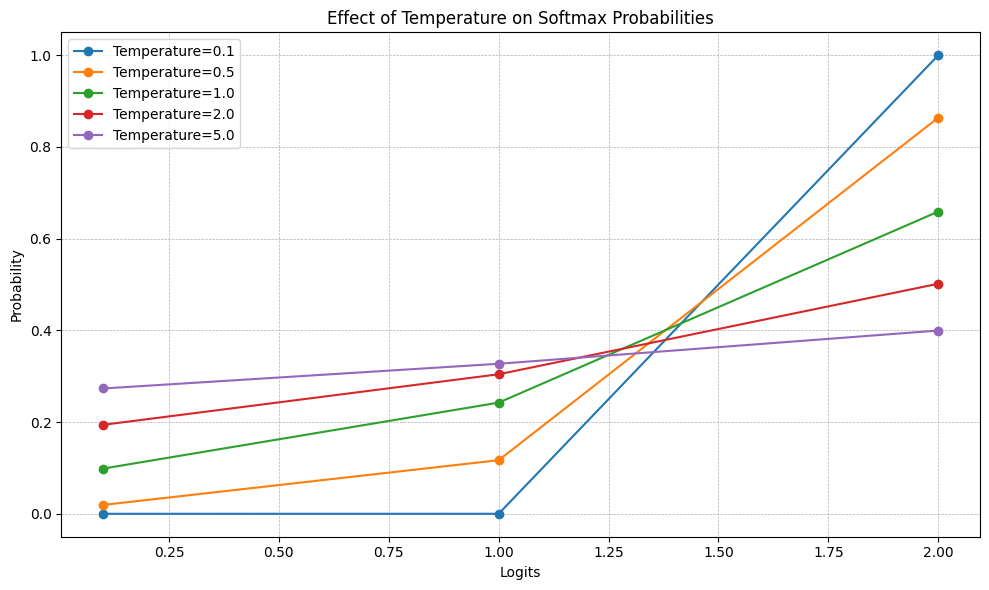

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define softmax function with temperature
def softmax(logits, temperature=1.0):
    logits_adjusted = logits / temperature
    exp_logits = np.exp(logits_adjusted - np.max(logits_adjusted))
    return exp_logits / exp_logits.sum()

logits = np.array([2.0, 1.0, 0.1])
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]

probs_list = []

# Compute probabilities for each temperature
for temp in temperatures:
    probs_list.append(softmax(logits, temp))

# Plotting
plt.figure(figsize=(10, 6))

for i, prob in enumerate(probs_list):
    plt.plot(logits, prob, '-o', label=f"Temperature={temperatures[i]}")

plt.title("Effect of Temperature on Softmax Probabilities")
plt.xlabel("Logits")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
